In [2]:
import sys
sys.path.insert(0, '.')
from utils import *

# Time Series graphics

## Time plots

* The obvious graph to start is a time plot.

In [3]:
ansett = pd.read_csv("data/ansett.csv")

In [4]:
ansett

,Week,Airports,Class,Passengers
0,1989 W28,ADL-PER,Business,193
1,1989 W29,ADL-PER,Business,254
2,1989 W30,ADL-PER,Business,185
3,1989 W31,ADL-PER,Business,254
4,1989 W32,ADL-PER,Business,191
...,...,...,...,...
7402,1992 W43,SYD-PER,First,203
7403,1992 W44,SYD-PER,First,137
7404,1992 W45,SYD-PER,First,161
7405,1992 W46,SYD-PER,First,155


In [5]:
ansett['Week'] = ansett['Week'] + '1'  # Adiciona um dia específico para obter o início da semana
ansett['Week'] = pd.to_datetime(ansett['Week'], format='%Y W%W%w')

ansett.set_index('Week', inplace=True)


In [6]:
melsyd_economy = ansett.loc[(ansett['Airports']=="MEL-SYD")&(ansett['Class']=="Economy")].copy()
melsyd_economy['Passengers'] = melsyd_economy['Passengers']/1000

Text(0, 0.5, "Passengers ('000)")

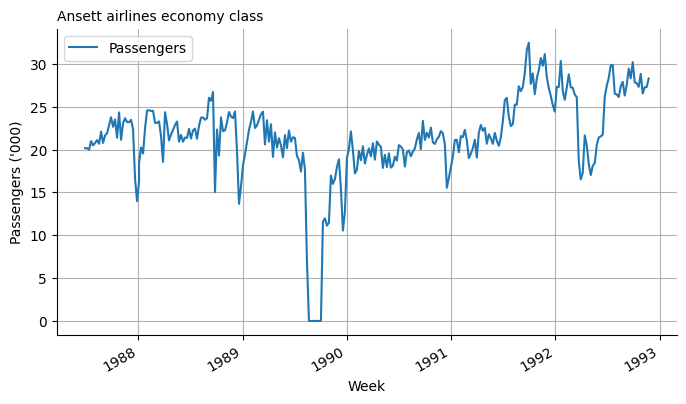

In [7]:
melsyd_economy[['Passengers']].plot(grid=True, title="Ansett airlines economy class");
plt.ylabel("Passengers ('000)")

* There was a period in 1989 when no passengers were carried — this was due to an industrial dispute.
* There was a period of reduced load in 1992. This was due to a trial in which some economy class seats were replaced by business class seats.
* A large increase in passenger load occurred in the second half of 1991.
* There are some large dips in load around the start of each year. These are due to holiday effects.
* There is a long-term fluctuation in the level of the series which increases during 1987, decreases in 1989, and increases again through 1990 and 1991.


In [8]:
a10 = pd.read_csv("data/a10.csv")

In [9]:
a10

,Month,total_cost
0,1991 Jul,3.526591
1,1991 Aug,3.180891
2,1991 Sep,3.252221
3,1991 Oct,3.611003
4,1991 Nov,3.565869
...,...,...
199,2008 Feb,21.654285
200,2008 Mar,18.264945
201,2008 Apr,23.107677
202,2008 May,22.912510


In [10]:
a10["Month"] = pd.to_datetime(a10["Month"], "ME")


/var/folders/72/x6_kg98117nd5xkqbx_bl3dc0000gn/T/ipykernel_1439/1254621549.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  a10["Month"] = pd.to_datetime(a10["Month"], "ME")


AssertionError: 

In [11]:
a10

,Month,total_cost
0,1991 Jul,3.526591
1,1991 Aug,3.180891
2,1991 Sep,3.252221
3,1991 Oct,3.611003
4,1991 Nov,3.565869
...,...,...
199,2008 Feb,21.654285
200,2008 Mar,18.264945
201,2008 Apr,23.107677
202,2008 May,22.912510


In [12]:
a10["Month"] = a10["Month"].str.split().str[1] + ' ' + a10["Month"].str.split().str[0]

# Converta para datetime
a10["Month"] = pd.to_datetime(a10["Month"], format='%b %Y')


In [13]:
a10.set_index("Month", inplace=True)

Text(0, 0.5, '$(millions)')

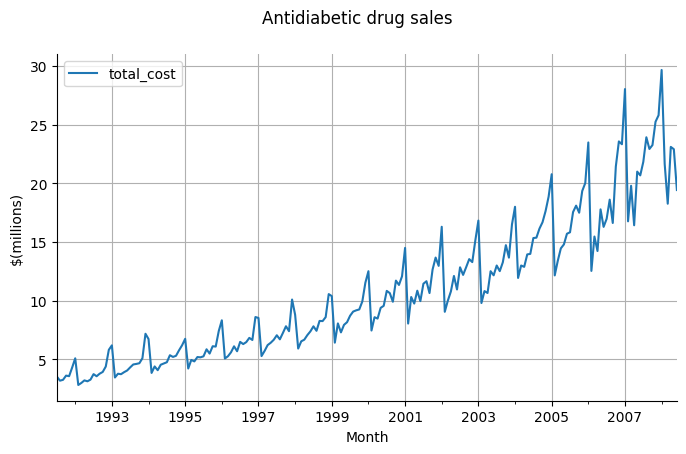

In [14]:
a10.plot(grid=True)
plt.suptitle('Antidiabetic drug sales')
plt.ylabel("$(millions)")

* Clear increasing trend
* Strong seasonal pattern

## Time series patterns

* Trend: a long-term increase or decrease in the data. It does not have to be linear.
* Seasonal: seasonal factors such as the time of the year or the day of the week. Fixed and known period.
* Cyclic: data exhibit rises and falls that are not of a fixed frequency.


<img src="https://otexts.com/fpp3/fpp_files/figure-html/fourexamples-1.png"  width="1000"/>
<!-- ![image](https://otexts.com/fpp3/fpp_files/figure-html/fourexamples-1.png)

1. Top left: monthly house sales. Strong seasonality within each year. Some cyclic behaviour with a period of about 6-10 years. No apparent trend.
2. Top right: US treasury bill contracts (results from the Chicago market for 100 consecutive trading days in 1981). No seasonality, obvious trend. If this series was longer, we would probably see that there is no trend, but a cycle.
3. Bottom left: Australian quarterly electricity production. Strong increasing trend, strong seasonality.
4. bottom right: Daily Change in Google closing stock price. No trend, no seasonality, no cyclic.

## Seasonal plots

* Similar to a time plot, but the data are plotted against the individual "seasons"

In [15]:
def seasonalize(data, column, period='year'):
    if period.lower() in ('year', 'y'):
        d = data.assign(
            __period = data.index.year,
            __x = data.index.dayofyear)
    elif period.lower() in ('week', 'w'):
        d = data.assign(
            __period = 100*data.index.year + data.index.isocalendar().week,
            __x = data.index.dayofweek
                + (data.index.hour + data.index.minute/60 + data.index.second/3600) / 24)
    elif period.lower() in ('day', 'd'):
        d = data.assign(
            __period = data.index.date,
            __x = data.index.hour + data.index.minute/60 + data.index.second/3600)
    d = (
        d
        .sort_values('__x')
        .groupby('__period')
        .pipe(summarize, lambda x: {'time': list(x.__x), column: list(x[column])})
    )
    return d

def plot_seasonal(
        data, column,
        period='year',
        cmap='viridis',
        labels='',
        figsize=None,
        ax=None,
        **kw):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = ax.figure, ax
    d = seasonalize(data, column, period)
    cm = plt.get_cmap(cmap)
    for (i, p) in enumerate(d.index):
        color = cm(i / len(d))
        x, y = d.time.loc[p], d[column].loc[p]
        ax.plot(x, y, color=color, label=str(p), **kw)
        if labels in 'right both'.split():
            ax.text(x[-1], y[-1], str(p), color=color, ha='center', va='center')
        if labels in 'left both'.split():
            ax.text(x[0], y[0], str(p), color=color, ha='center', va='center')
    return ax

In [16]:
a10

,total_cost
Month,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


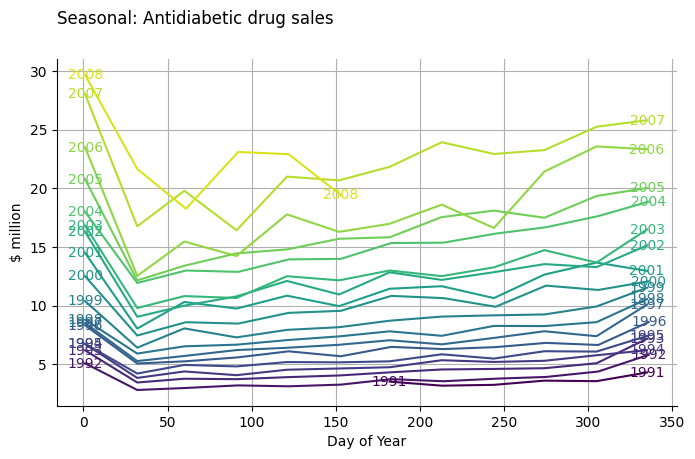

In [17]:
ax = plot_seasonal(a10, 'total_cost', labels='both', figsize=sizets)
suptitle('Seasonal: Antidiabetic drug sales')
ax.set(xlabel='Day of Year', ylabel='$ million')
ax.grid()

### Multiple seasonal

* Sometimes, a series has more than one period

In [18]:
vic_elec = (
    pd.read_csv('data/vic_elec.csv')
    .pipe(compute, lambda x: dict(Time = pd.to_datetime(x.Time)))
    .set_index('Time')
)

CPU times: user 396 ms, sys: 12 ms, total: 408 ms
Wall time: 408 ms


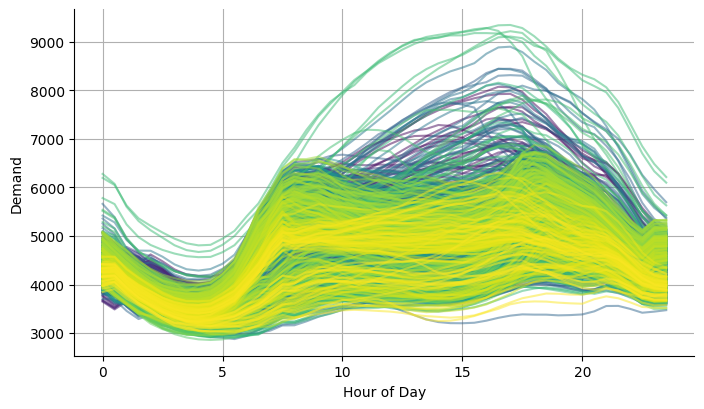

In [19]:
%%time
ax = plot_seasonal(vic_elec, 'Demand', period='d', alpha=.5, figsize=sizets)
ax.set(xlabel='Hour of Day', ylabel='Demand')
ax.grid()

CPU times: user 71.4 ms, sys: 3.62 ms, total: 75 ms
Wall time: 74.9 ms


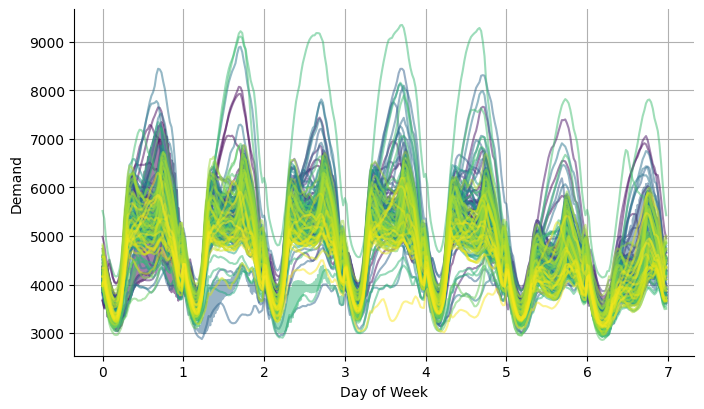

In [20]:
%%time
ax = plot_seasonal(vic_elec, 'Demand', period='w', alpha=.5, figsize=sizets)
ax.set(xlabel='Day of Week', ylabel='Demand')
ax.grid()

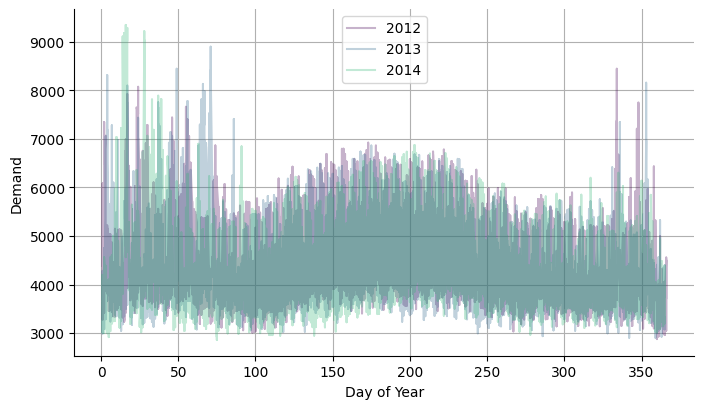

In [21]:
ax = plot_seasonal(vic_elec, 'Demand', period='y', alpha=.3, figsize=sizets)
ax.legend()
ax.set(xlabel='Day of Year', ylabel='Demand')
ax.grid()


## Seasonal subseries plots

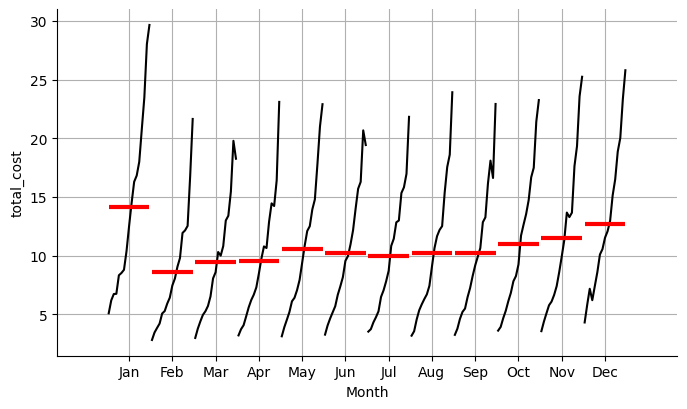

In [22]:
fig, ax = plt.subplots()
sm.graphics.tsa.month_plot(a10.total_cost, ax=ax)
ax.set(xlabel='Month', ylabel='total_cost')
ax.grid()

## Scatterplots

* Sometimes we want to explore relationships between time series
* The plots below show two time series: half-hourly electricity demand and temperature for 2014, Victoria, Australia

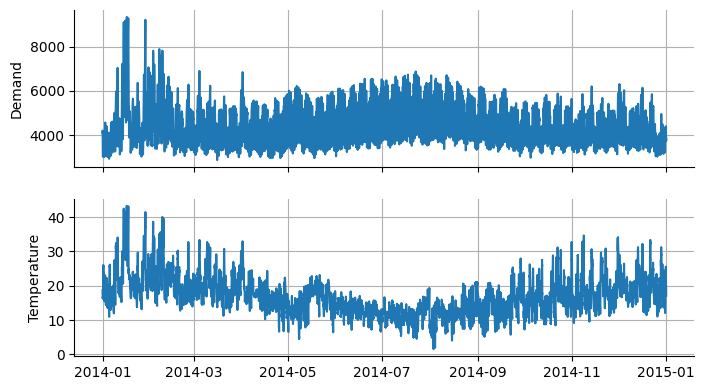

In [23]:
fig, axs = plt.subplots(2, sharex=True)
d = vic_elec[vic_elec.index.year == 2014]
ax = axs[0]
ax.plot(d.Demand)
ax.set(xlabel='', ylabel='Demand')
ax.grid()

ax = axs[1]
ax.plot(d.Temperature)
ax.set(xlabel='', ylabel='Temperature')
ax.grid()

We can look at the relationship between these two time series using a scatter plot

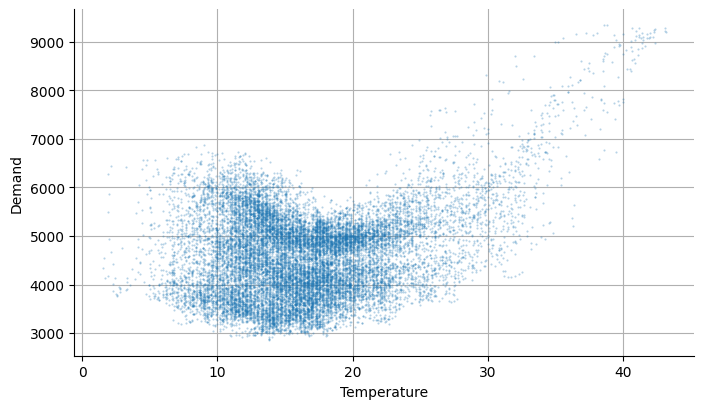

In [24]:
fig, ax = plt.subplots()
ax.plot(d.Temperature, d.Demand, '.', alpha=.33, ms=1)
ax.set(xlabel='Temperature', ylabel='Demand')
ax.grid()

* High demand occurs when temperatures are high
* Heating effect: demand also increases for very low temperatures

### Pair plots and Lag plots

In [25]:
d = pd.read_csv('data/aus_production.csv')
recent_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .pipe(compute, lambda x: dict(Year=x.Date.dt.year))
    .query('Year >= 1992')
    .set_index('Date', drop=False)
    .drop(columns='Date Year'.split())
)

recent_production


/var/folders/72/x6_kg98117nd5xkqbx_bl3dc0000gn/T/ipykernel_1439/4107558430.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))


,Quarter,Beer,Tobacco,Bricks,Cement,Electricity,Gas
Date,,,,,,,
1992-01-01,1992 Q1,443,5777.0,383.0,1289,38332,117
1992-04-01,1992 Q2,410,5853.0,404.0,1501,39774,151
1992-07-01,1992 Q3,420,6416.0,446.0,1539,42246,175
1992-10-01,1992 Q4,532,5825.0,420.0,1568,38498,129
1993-01-01,1993 Q1,433,5724.0,394.0,1450,39460,116
...,...,...,...,...,...,...,...
2009-04-01,2009 Q2,398,NaN,NaN,2160,57471,238
2009-07-01,2009 Q3,419,NaN,NaN,2325,58394,252
2009-10-01,2009 Q4,488,NaN,NaN,2273,57336,210


/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/pyt

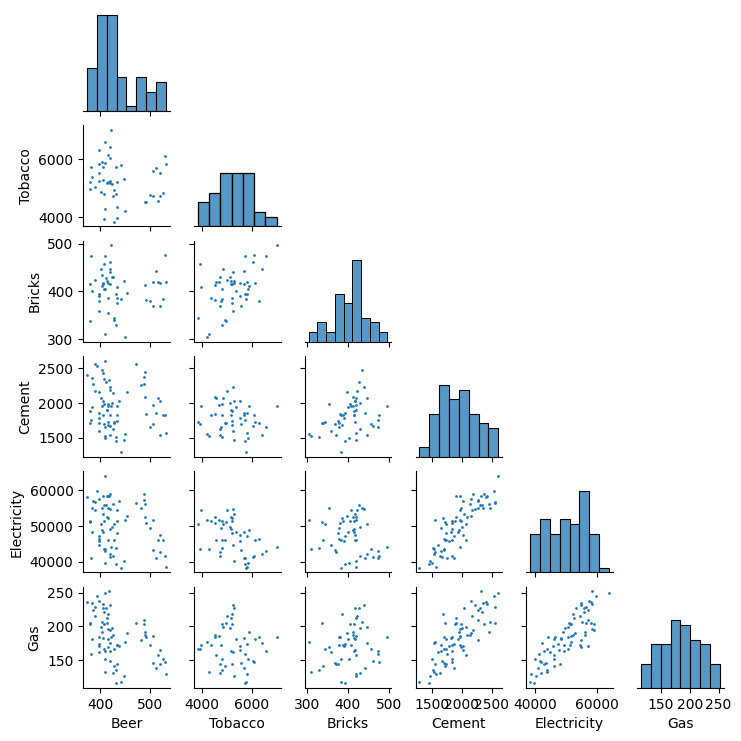

In [26]:
sns.pairplot(recent_production, plot_kws=dict(linewidth=0, s=4), corner=True, height=1.25)

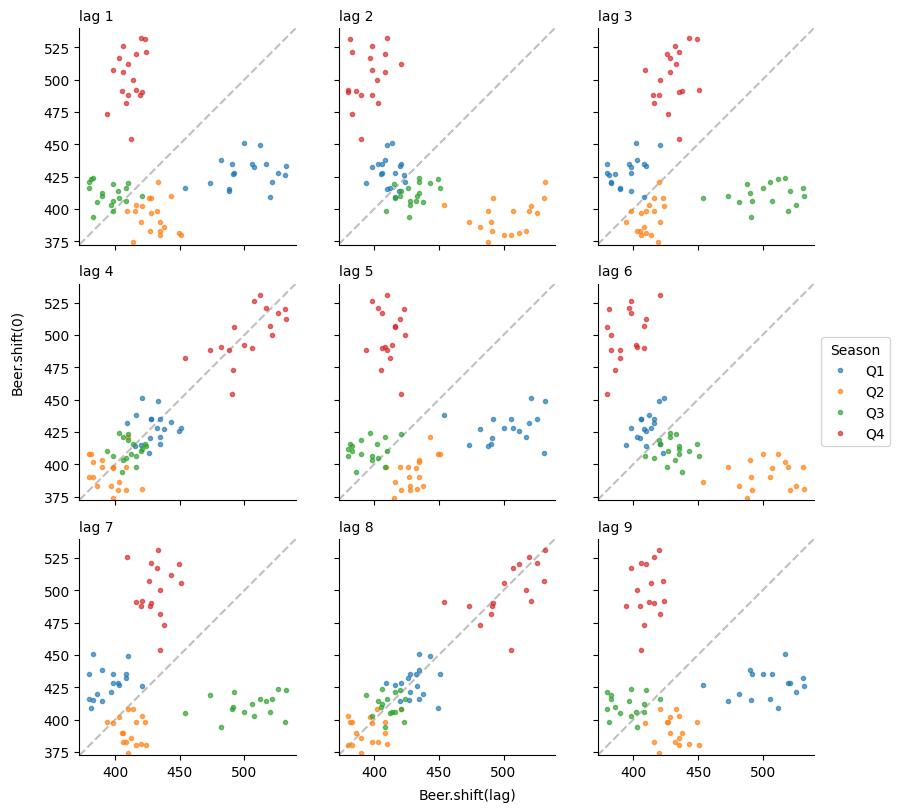

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(9,8), sharex=True, sharey=True)
D = recent_production.copy()
D = pd.DataFrame({lag: D.Beer.shift(lag) for lag in range(10)})
D['q'] = recent_production.index.quarter
for (i, ax) in enumerate(axs.ravel()):
    for (q, d) in D.groupby('q'):
        ax.plot(d[i+1], d[0], '.', alpha=.66, label=f'Q{q}')
        lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha=.25, zorder=-10)
    ax.set(xlim=lim, ylim=lim, title=f'lag {i+1}', aspect='equal')
axs.ravel()[5].legend(loc='center left', bbox_to_anchor=[1, .5], title='Season')
fig.text(.5, -.01, 'Beer.shift(lag)', ha='center', va='bottom')
fig.text(0, .5, 'Beer.shift(0)', ha='center', va='bottom', rotation=90)
plt.tight_layout()

* The colours indicate the quarter
* The relationship is strongly positive at lags 4 and 8

## Autocorrelation

* Measures the linear relationship between lagged values of a time series
* $r_1$ measures the relationship between $y_t$ and $y_{t-1}$
* $r_2$ measures the relationship between $y_t$ and $y_{t-2}$
* ...

$$r_{k} = \frac{\sum\limits_{t=k+1}^T (y_{t}-\bar{y})(y_{t-k}-\bar{y})}
{\sum\limits_{t=1}^T (y_{t}-\bar{y})^2},$$

where $T$ is the length of the time series.
* The autocorrelation coefficients make up the autocorrelation function or ACF

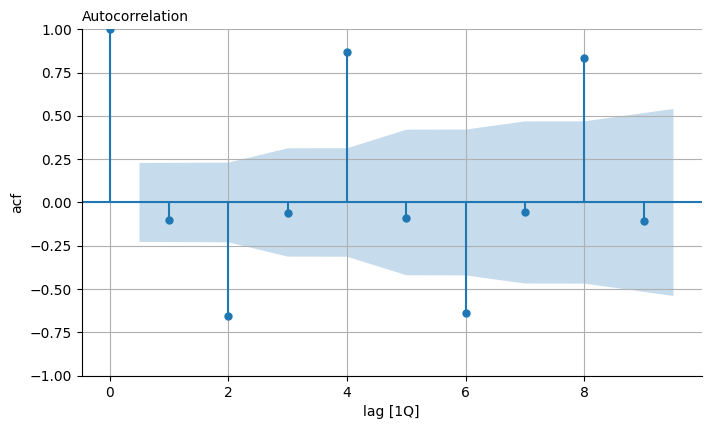

In [28]:
fig, ax = plt.subplots(figsize=sizets)
sm.graphics.tsa.plot_acf(recent_production.Beer, ax=ax, lags=9)
ax.set(ylim=(-1,1), xlabel='lag [1Q]', ylabel='acf')
plt.grid()

### Trend and seasonality in ACF plots
* When there is a trend --> small lags tend to be large and positive
* When data is seasonal --> autocorrelations will be larger for the seasonal lags

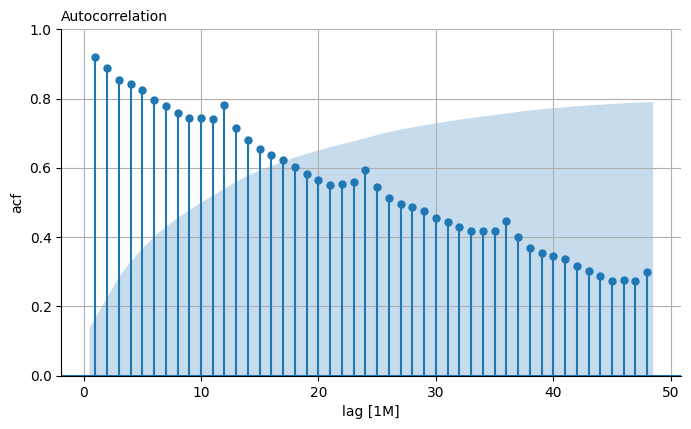

In [29]:
fig, ax = plt.subplots(figsize=sizets)
sm.graphics.tsa.plot_acf(a10.total_cost, ax=ax, lags=np.r_[1:48+1])
ax.set(ylim=(0,1), xlabel='lag [1M]', ylabel='acf')
plt.grid()

### White Noise

* Time series that show no autocorrelation are called white noise

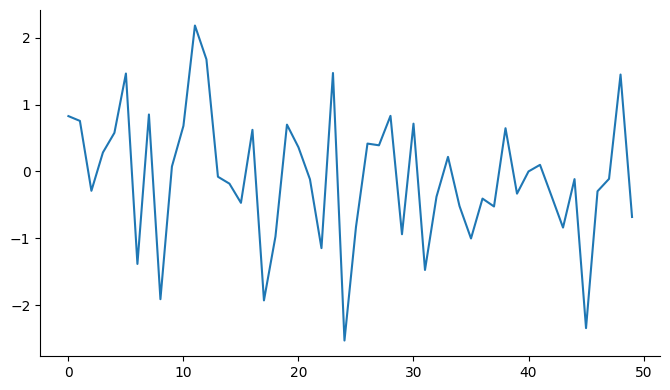

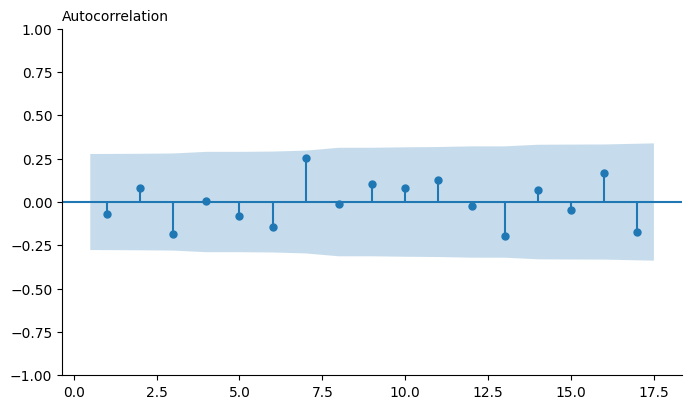

In [31]:
white_noise = np.random.normal(size=50)
plt.plot(white_noise)
sm.graphics.tsa.plot_acf(white_noise, lags=np.r_[1:18]);

# Time series decomposition

Two decomposition models:

* Additive
$$y_{t} = S_{t} + T_{t} + R_t$$
* Multiplicative

$$y_{t} = S_{t} \times T_{t} \times R_t$$

## Components of Time Series

* Level. The baseline value for the series if it were a straight line.
* Trend. The optional and often linear increasing or decreasing behavior of the series over time.
* Seasonality. The optional repeating patterns or cycles of behavior over time.
* Noise. The optional variability in the observations that cannot be explained by the model.

All time series have a level, most have noise, and the trend and seasonality are optional.